# Glove from Scratch

### Library Imports

This section imports all the necessary libraries required for the project. The libraries are used for various purposes such as numerical operations, deep learning model creation and optimization, data visualization, and natural language processing. Specifically:

- `numpy`: Fundamental package for scientific computing with Python.
- `torch`: A deep learning framework that provides a flexible platform for research and production.
- `torch.nn`: A sub-library of PyTorch for building neural networks.
- `torch.optim`: A sub-library of PyTorch for optimizing models.
- `matplotlib`: A plotting library for creating static, interactive, and animated visualizations in Python.
- `nltk`: A leading platform for building Python programs to work with human language data (Natural Language Processing).
- `json`  A library for parsing and manipulating JSON data
- `string`  A library for processing string



In [64]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
import time
import nltk
from nltk.corpus import reuters
import json 
import string

In this section, we ensure that the necessary libraries are properly installed and check their versions. This is a crucial step to maintain reproducibility and debug any version-related issues. We are checking versions for the following libraries:
- `matplotlib` for plotting and visualizations.
- `numpy` (imported as `np`) for numerical operations.
- `torch` for deep learning tasks.


In [65]:
# Check the version of matplotlib, numpy, and torch to ensure compatibility and reproducibility
matplotlib.__version__, np.__version__, torch.__version__

('3.7.2', '1.26.0', '2.1.1')

In this section, we download additional resources from the NLTK library. These resources are essential for natural language processing tasks involving the Reuters corpus and tokenization. Specifically:

- `reuters`: A dataset of news documents. The Reuters corpus is widely used in text classification tasks.
- `punkt`: A tokenizer model. This is used by the NLTK library to split texts into lists of sentences or lists of words.


In [66]:
nltk.download('reuters')  # Download the Reuters corpus for text classification tasks
nltk.download('punkt')  # Download the Punkt tokenizer model for sentence splitting

[nltk_data] Downloading package reuters to
[nltk_data]     /Users/shafisourov/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shafisourov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1. Load data


Here we load the Reuters corpus into our workspace. The `reuters.sents()` function provided by NLTK is used to load the sentences of the Reuters corpus. This corpus will be used for various natural language processing tasks, such as text classification, sentence structure analysis, etc. The corpus is structured as a list of sentences, and each sentence is a list of words.


In [67]:
corpus_nltk = reuters.sents()  # Load sentences from the Reuters corpus using NLTK

### Sentence Flattening and Tokenization

In this section, we perform two key preprocessing steps on the Reuters corpus:

1. **Sentence Flattening**: We convert the list of sentences (where each sentence is a list of words) into a list of sentences where each sentence is a single string. This makes it suitable for further processing such as tokenization.

2. **Tokenization**: We then tokenize each sentence. Tokenization involves splitting sentences into individual words or tokens. This is a crucial step in natural language processing as it prepares the text data for techniques like word embedding or bag-of-words. We also convert all the text to lowercase to maintain consistency and reduce the complexity of the dataset.


In [68]:
# Flatten the list of sentences and then tokenize each sentence
corpus_nltk = [" ".join(sent) for sent in corpus_nltk]
corpus_nltk = [nltk.word_tokenize(sent.lower()) for sent in corpus_nltk]

In [170]:
flatten = lambda l: [item for sublist in l for item in sublist]
#total passages , total words in the corpus

print("Total Passages in the corpus",len(corpus_nltk))
print("Total Tokens in the corpus",len(list(set(flatten(corpus_nltk)))))

Total Passages in the corpus 54716
Total Tokens in the corpus 30996


### Creating a Subset of the Corpus

For the purpose of efficiency or demonstration, we often work with a smaller subset of the entire dataset. In this section, we create a smaller corpus named `corpus` by selecting the first 500 entries from the preprocessed `corpus_nltk`. This subset will be used for subsequent operations, reducing the computational load and allowing for quicker iterations during the development and testing phases.


In [70]:
corpus = corpus_nltk[:500]  # Select the first 500 elements to create a smaller corpus for quick operations

### Vocabulary Creation

In this section, we prepare the vocabulary of our corpus. This involves two main steps:

1. **Flattening the Corpus**: We convert our corpus from a list of sentences (where each sentence is a list of tokens) into a flat list of tokens. This is done using a lambda function for list flattening.

2. **Creating Unique Vocabulary**: We then convert our flat list of tokens into a set, which automatically removes duplicates, giving us a list of unique words in our corpus. This vocabulary (`vocabs`) will be fundamental for tasks such as word embedding or encoding our textual data for machine learning models.

Note: In this process, we do not include the special token `<UNK>` which is often used to represent unknown words in NLP tasks.


In [71]:
#find unique words
flatten = lambda l: [item for sublist in l for item in sublist]
#assign unique integer
vocabs = list(set(flatten(corpus))) #all the words we have in the system - <UNK>

In [72]:
#append UNK
vocabs.append('<UNK>')

In [73]:
len(vocabs)

2678

In [173]:
print("Total Passages Taken for training ",len(corpus))
print("Total Tokens Taken for training",len(vocabs))

Total Passages Taken for training  500
Total Tokens Taken for training 2678


#### Creating Word to Index Mapping

After creating our vocabulary, it's essential to be able to convert our textual data to numerical format, as most algorithms require numerical input. In this section, we create a mapping from words to unique integers. 

This mapping (`word2index`) will serve as a dictionary where each word from our vocabulary is associated with a unique


In [74]:
#create handy mapping between integer and word
word2index = {v:idx for idx, v in enumerate(vocabs)}

In [75]:
word2index['<UNK>'] = len(vocabs)-1

#### Creating Index to Word Mapping

While the word to index mapping is crucial for encoding textual data, it's equally important to be able to decode the numerical data back to text. In this section, we create a reverse mapping from indices to words.

This reverse mapping (`index2word`) allows us to convert our numerical data back into readable text, which is especially useful during the testing phase or when we want to interpret the output of our model. The dictionary is created by reversing the `word2index` mapping.

Finally, we demonstrate how to use this mapping by retrieving the word associated with the index 0.


In [76]:
index2word = {v: k for k, v in word2index.items()}  # Create a reverse mapping of integer to word

## 2. Build Co-occurence Matrix X

Here, we need to count the co-occurence of two words given some window size.  We gonna use window size of 1.

In this section, we generate skip-grams from the given corpus. Skip-grams are pairs of words that capture the context of words within a document. For each word in a document, we consider its immediate neighbors as its context. We construct pairs (center, outside) where 'center' is the current word, and 'outside' consists of its immediate neighbors. These pairs are then collected into a list of skip-grams. This approach is useful in various NLP tasks to understand and preserve the local context of words.


In [77]:
from collections import Counter

# Flattening the corpus into a 1D list of elements
# Assuming 'flatten' is a function that properly flattens the corpus
X_i = Counter(flatten(corpus))

In [78]:
# Initialize an empty list to store the skip-grams
skip_grams = []

# Iterate over each document in the corpus
for doc in corpus:
    # Iterate over each word in the document, except the first and last words
    for i in range(1, len(doc)-1):
        center = doc[i]  # Current word as the center word
        outside = [doc[i-1], doc[i+1]]  # Words immediately before and after the center word
        
        # Create skip-grams and add them to the list
        # Each skip-gram is a pair (center word, outside word)
        for each_out in outside:
            skip_grams.append((center, each_out))

In [79]:
X_ik_skipgrams = Counter(skip_grams)

GloVe includes a weighting function to scale down too frequent words.

![Glove Weighting Function](screenshots/glove_weighting_func.png)


#### Weighting Function for Word Co-occurrences

This section defines the `weighting` function, which computes a weighted value for a pair of words based on their co-occurrence frequency. The function aims to scale the co-occurrence frequency by a factor that diminishes as the frequency increases, up to a certain threshold (`x_max`). The scaling factor is controlled by the parameter `alpha`. If the co-occurrence frequency is not available, Laplace smoothing is applied by setting the frequency to 1. This function is useful in word embedding methods where the relationship between words is captured by their co-occurrence patterns within a certain context.


In [80]:
def weighting(w_i, w_j, X_ik):
    # Check whether the co-occurrences between w_i and w_j are available in X_ik
    try:
        x_ij = X_ik[(w_i, w_j)]
    # If not exist, apply Laplace smoothing by setting co-occurrence to 1
    except:
        x_ij = 1
    
    # Set the maximum co-occurrence value for scaling
    x_max = 100
    # Set the scaling exponent
    alpha = 0.75
    
    # If co-occurrence does not exceed x_max, scale it by (x_ij / x_max)^alpha
    if x_ij < x_max:
        result = (x_ij / x_max) ** alpha
    # Otherwise, if co-occurrence is greater than or equal to x_max, set the result to 1
    else:
        result = 1
    
    # Return the weighted result
    return result


#### Co-occurrence and Weight Calculation

In this section, we calculate the co-occurrence of each possible pair of words (bigrams) from the vocabulary and then apply the previously defined `weighting` function to compute a weight for each bigram. The co-occurrences are stored in `X_ik`, which keeps track of the co-occurrence count for each word pair. The `weighting_dic` dictionary is used to store the weights of these co-occurrences. The weights are intended to reflect the strength and significance of the co-occurrence, adjusted by the `weighting` function to account for the frequency and provide stability in the values.


In [81]:
from itertools import combinations_with_replacement

X_ik = {} #keeping the co-occurences
weighting_dic = {} #already scale the co-occurences using the weighting function

for bigram in combinations_with_replacement(vocabs, 2):
    if X_ik_skipgrams.get(bigram):  #if the pair exists in our corpus
        co = X_ik_skipgrams[bigram]
        X_ik[bigram] = co + 1 #for stability
        X_ik[(bigram[1], bigram[0])] = co + 1 #basically apple, banana = banana, apple
    else:
        pass
    
    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

## 3. Prepare train data

#### Batch Preparation for Model Training

This function, `random_batch`, is designed to prepare batches of data for training a word embedding model. It randomly selects skip-grams and gathers the necessary components for the batch: inputs (center words), labels (context words), co-occurrence counts, and weighting values. The co-occurrence counts are log-transformed for numerical stability and scaling purposes. The weighting values are retrieved from a pre-computed dictionary, reflecting the significance of each word pair's co-occurrence. This function is crucial for stochastic training approaches where batches of data are used to update the model's parameters iteratively.


In [82]:
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    # Initialize lists to hold batch data
    random_inputs, random_labels, random_coocs, random_weightings = [], [], [], []
    
    # Convert skip-grams to their corresponding indices
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    # Randomly choose indices based on the batch size
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False)
    
    # For each randomly chosen index, gather the batch data
    for index in random_index:
        # Append the center word index
        random_inputs.append([skip_grams_id[index][0]])
        # Append the context word index
        random_labels.append([skip_grams_id[index][1]])
        
        # Append the log of co-occurrence count (with Laplace smoothing)
        pair = skip_grams[index]  # Get the original word pair
        cooc = X_ik.get(pair, 1)  # Get co-occurrence count, default to 1 if not found
        random_coocs.append([math.log(cooc)])
        
        # Append the weighting for the word pair
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
        
    # Return the batch data as numpy arrays
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)


#### Testing the method

In [83]:
batch_size = 2
x, y, cooc, weighting = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)

In [84]:
x

array([[ 185],
       [1704]])

In [85]:
y

array([[1429],
       [1551]])

In [86]:
cooc

array([[0.69314718],
       [1.79175947]])

In [87]:
weighting

array([[0.05318296],
       [0.12123093]])

## 4. Model & Training

![alternative text](screenshots/glove.png)


#### GloVe Model for Word Embeddings

This class, `Glove`, implements the GloVe model for generating word embeddings. The GloVe model captures global statistics of word co-occurrences in a corpus and uses them to form vector representations of words. This implementation includes embedding layers for the center and outside words, as well as bias terms for each. The `forward` method computes the GloVe loss function, which is designed to encourage the dot product of the embeddings of words that co-occur frequently to be close to the logarithm of their co-occurrence probability, adjusted by the respective bias terms and a weighting factor for each word pair.


In [88]:
class Glove(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Glove, self).__init__()
        # Embeddings for center words
        self.center_embedding  = nn.Embedding(voc_size, emb_size)
        # Embeddings for context (outside) words
        self.outside_embedding = nn.Embedding(voc_size, emb_size)
        
        # Bias terms for center words
        self.center_bias       = nn.Embedding(voc_size, 1) 
        # Bias terms for context (outside) words
        self.outside_bias      = nn.Embedding(voc_size, 1)
    
    def forward(self, center, outside, coocs, weighting):
        # Retrieve the embeddings for the center words
        center_embeds  = self.center_embedding(center)  # (batch_size, 1, emb_size)
        # Retrieve the embeddings for the outside words
        outside_embeds = self.outside_embedding(outside)  # (batch_size, 1, emb_size)
        
        # Retrieve and squeeze the bias for the center words
        center_bias    = self.center_bias(center).squeeze(1)
        # Retrieve and squeeze the bias for the outside words
        target_bias    = self.outside_bias(outside).squeeze(1)
        
        # Compute the dot product of center and outside word embeddings
        inner_product  = outside_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        
        # Compute the GloVe loss as the weighted squared error between
        # the log co-occurrence counts and the model predictions (dot product + biases)
        loss = weighting * torch.pow(inner_product + center_bias + target_bias - coocs, 2)
        
        # Return the sum of the losses for the batch
        return torch.sum(loss)


In [89]:
#test our system
voc_size = len(vocabs)
emb_size = 2
model = Glove(voc_size, emb_size)

In [90]:
x_tensor = torch.LongTensor(x)
y_tensor = torch.LongTensor(y)
cooc_tensor = torch.FloatTensor(cooc)
weighting_tensor = torch.FloatTensor(weighting)

In [91]:
loss = model(x_tensor, y_tensor, cooc_tensor, weighting_tensor)

In [92]:
loss

tensor(2.0351, grad_fn=<SumBackward0>)

In [93]:
# Set the batch size and embedding size
batch_size     = 10  # mini-batch size
embedding_size = 2  # set to 2 for visualization purposes

# Initialize the GloVe model with the specified vocabulary size and embedding size
model          = Glove(voc_size, embedding_size)

# Initialize the loss function and the optimizer
criterion = nn.CrossEntropyLoss()  
# Initialize the optimizer (Adam) with the model parameters and a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)


#### Training Loop for GloVe Model

The code block represents the training loop for the GloVe model. During each epoch, a batch of data is prepared and processed through the model. The loss is computed based on the difference between the predicted and actual co-occurrence probabilities. The model's parameters are updated using backpropagation with the Adam optimizer. The loss for every thousandth epoch is printed, allowing monitoring of the training progress. The total training time and average training loss are printed after training completes, providing insights into the model's performance and efficiency.


In [117]:
num_epochs = 10000
total_loss = 0.0  # Initialize total loss

total_start = time.time()  # Start time for total training time
# Training
for epoch in range(num_epochs):
    
    start = time.time()
    
    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)
    input_batch  = torch.LongTensor(input_batch)         #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch)        #[batch_size, 1]
    cooc_batch   = torch.FloatTensor(cooc_batch)         #[batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch) #[batch_size, 1]
    
    optimizer.zero_grad()
    loss = model(input_batch, target_batch, cooc_batch, weighting_batch)
    
    loss.backward()
    optimizer.step()
    # Accumulate loss
    total_loss += loss.item()
    
    end = time.time()
    
    # Calculate time taken for the epoch
    epoch_mins, epoch_secs = divmod(end - start, 60)

    # Print the loss and time taken for the epoch
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins:.0f}m {epoch_secs:.0f}s")

# Compute average loss
average_loss = total_loss / num_epochs

total_end = time.time()  # End time for total training time
total_mins, total_secs = divmod(total_end - total_start, 60)

# Print the total training time and average loss
print(f"Total training time: {total_mins:.0f}m {total_secs:.0f}s")
print(f"Average training loss: {average_loss:.6f}")

Epoch: 1000 | cost: 1.878838 | time: 0m 0s
Epoch: 2000 | cost: 0.926595 | time: 0m 0s
Epoch: 3000 | cost: 0.616542 | time: 0m 0s
Epoch: 4000 | cost: 0.353751 | time: 0m 0s
Epoch: 5000 | cost: 0.831147 | time: 0m 0s
Epoch: 6000 | cost: 0.398903 | time: 0m 0s
Epoch: 7000 | cost: 0.520872 | time: 0m 0s
Epoch: 8000 | cost: 0.365187 | time: 0m 0s
Epoch: 9000 | cost: 0.263848 | time: 0m 0s
Epoch: 10000 | cost: 0.748213 | time: 0m 0s
Total training time: 1m 54s
Average training loss: 0.724803


## 5. Plot the embeddings


In [118]:
#list of vocabs
vocabs[:10]

['since',
 'rationalisation',
 'partners',
 'account',
 'reasonable',
 'drives',
 'protect',
 'plants',
 '5p',
 'us']

In [119]:
word = vocabs[0]

In [120]:
#numericalization
id = word2index[word]
id

0

In [121]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [122]:
#get the embedding by averaging
v_embed = model.center_embedding(id_tensor)
u_embed = model.outside_embedding(id_tensor)

v_embed, u_embed

(tensor([[ 0.3289, -0.1395]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 0.0063, -0.9862]], grad_fn=<EmbeddingBackward0>))

In [123]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed

tensor([[ 0.1676, -0.5629]], grad_fn=<DivBackward0>)

In [124]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.center_embedding(id_tensor)
    u_embed = model.outside_embedding(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

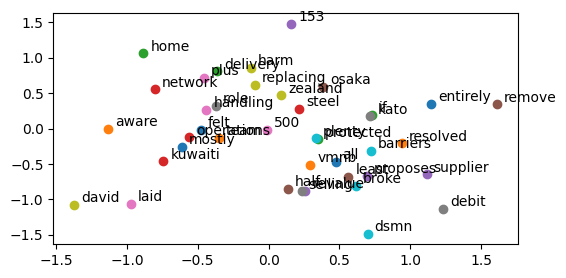

In [125]:
plt.figure(figsize=(6, 3))
for i, word in enumerate(vocabs[40:80]):
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 6. Cosine similarity

Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

If $p$ and $q$ is super similar, the result is 1 otherwise 0.

In [126]:
government = get_embed('government')
diplomatic = get_embed('diplomatic')
reporters = get_embed('reporters')

In [127]:
def cosine_similarity(A, B):
    # Compute the cosine similarity between vectors A and B
    dot_product = np.dot(A, B)  # Compute the dot product of A and B
    norm_a = np.linalg.norm(A)  # Compute the L2 norm (Euclidean norm) of vector A
    norm_b = np.linalg.norm(B)  # Compute the L2 norm (Euclidean norm) of vector B
    similarity = dot_product / (norm_a * norm_b)  # Compute the cosine similarity
    return similarity  # Return the cosine similarity

# Example usage of the cosine_similarity function
print("Similarity between 'business' and 'promotion ", cosine_similarity(np.array(government), np.array(diplomatic)))  
print("Similarity between 'business' and 'transactions' ",cosine_similarity(np.array(government), np.array(reporters))) 
print("Similarity between 'promotion' and 'transactions' ",cosine_similarity(np.array(diplomatic), np.array(reporters))) 

Similarity between 'business' and 'promotion  0.25696787056824827
Similarity between 'business' and 'transactions'  0.8779024894700882
Similarity between 'promotion' and 'transactions'  -0.2371672625967855


In [128]:
word2index_path = './config_model_files/word2index_GloVe_Scratch.json'  # Define the file path for word2index
index2word_path = './config_model_files/index2word_GloVe_Scratch.json'  # Define the file path for index2word

with open(word2index_path, 'w') as file:
    json.dump(word2index, file)  # Save the word2index dictionary to a JSON file

with open(index2word_path, 'w') as file:
    json.dump(index2word, file)  # Save the index2word dictionary to a JSON file


## 7. Saving the Preprocessed Corpus

After preprocessing the corpus (tokenization, cleaning, etc.), it's good practice to save it for future use. This section involves saving the preprocessed corpus to a text file. Each sentence in the corpus is joined into a single string and written to the file, with sentences separated by newlines. This format is useful for:

- Preserving the preprocessed data for future analysis or processing.
- Using the corpus directly in applications that require text input.
- Ensuring consistency and reproducibility in different stages of the project or in different environments.

The corpus is saved in a plain text format, making it easily accessible and readable.


In [129]:
corpus_path = './config_model_files/corpus_GloVe_Scratch.txt'  # Define the file path for the corpus

with open(corpus_path, 'w') as file:
    for sentence in corpus:
        file.write(' '.join(sentence) + '\n')  # Write each sentence to the file, separated by a newline


#### Saving Word2Vec Model and Configuration

To ensure the preservation and reusability of our Word2Vec model, we save both its state and configuration to separate files. This is a common practice for archiving and sharing machine learning models. The process involves:

1. **Saving Model State**: We save the state of the Word2Vec model using `torch.save()`. This includes the learned parameters and embeddings.

2. **Saving Configuration**: We save the model's configuration, such as vocabulary size (`voc_size`) and embedding size (`emb_size`), to a JSON file. This configuration is useful for understanding the model's architecture and for initializing a new model with the same settings.

After saving, we print the paths to the saved files for reference.


In [130]:
# Model parameters
voc_size = len(word2index)
emb_size = emb_size  # or whatever was our configuration

# Save the model state and configuration
model_path = './config_model_files/word2vec_model_GloVe_Scratch.pth'
config_path = './config_model_files/word2vec_config_GloVe_Scratch.json'
torch.save(model.state_dict(), model_path)

with open(config_path, 'w') as config_file:
    config = {'voc_size': voc_size, 'emb_size': emb_size}
    json.dump(config, config_file)

print(f"Model saved to {model_path}")
print(f"Configuration saved to {config_path}")


Model saved to ./config_model_files/word2vec_model_GloVe_Scratch.pth
Configuration saved to ./config_model_files/word2vec_config_GloVe_Scratch.json


## 8. Inference (Loading Model with an Application of Query-Based Passage Retrieval from Trained Corpus)

here's a simplified high-level overview of the process in less than five steps:

- Preprocess and Embed: Convert the input query and each passage in the corpus into numerical embeddings by averaging their word embeddings.
- Calculate Similarities: Compute the similarity between the query's embedding and each passage's embedding using the dot product.
- Rank Passages: Rank the passages based on their similarity scores with the query.
- Retrieve Top Passages: Select and return the top N passages that have the highest similarity scores with the query.

#### Loading Word-Index Mappings

In [139]:
word2index_path = './config_model_files/word2index_GloVe_Scratch.json'  
index2word_path = './config_model_files/index2word_GloVe_Scratch.json' 

with open(word2index_path, 'r') as file:
    word2index = json.load(file)  # Load the word2index dictionary from the JSON file

with open(index2word_path, 'r') as file:
    index2word = json.load(file)  # Load the index2word dictionary from the JSON file


#### Loading the Preprocessed Corpus

In [140]:
corpus_path = './config_model_files/corpus_GloVe_Scratch.txt' 
def load_corpus(file_path):
    corpus = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            # Strip removes leading/trailing whitespace
            line = line.strip()
            # print(line)
            if line:  # Add non-empty lines to the corpus
                corpus.append(line)
    return corpus

# Load the corpus
corpus = load_corpus(corpus_path)


In [141]:
len(corpus)

500

#### Loading Word2Vec Model and Configuration

To use a previously trained Word2Vec model, we load both its configuration and state dictionary. This allows us to recreate the model with the same architecture and settings as before. The process involves:

1. **Loading Configuration**: We load the model's configuration from a JSON file, which includes parameters such as vocabulary size (`voc_size`) and embedding size (`emb_size`).

2. **Initializing Model**: We initialize a new Word2Vec model with the loaded configuration, creating a model that matches the original settings.

3. **Loading Model State**: We load the state dictionary (learned parameters and embeddings) into the initialized model. This restores the model's weights to their trained values.

4. **Setting Model to Evaluation Mode**: We set the loaded model to evaluation mode using `model.eval()`. This mode is typically used when making predictions rather than training.

After loading, we confirm the successful loading of the model.


In [142]:
model_path = './config_model_files/word2vec_model_Glove_Scratch.pth'
config_path = './config_model_files/word2vec_config_Glove_Scratch.json'

# Load the model's configuration from a JSON file
with open(config_path, 'r') as config_file:
    config = json.load(config_file)

# Retrieve the configuration values
voc_size = config['voc_size']  # Vocabulary size
emb_size = config['emb_size']  # Embedding size

# Initialize a new Word2Vec model with the loaded configuration
loaded_model = Glove(voc_size, emb_size)

# Load the state dictionary (model parameters) into the initialized model
loaded_model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode (useful for inference)
loaded_model.eval()

# Confirm successful model loading
print("Model loaded successfully")

Model loaded successfully


##### Converts the entire text to lowercase to ensure uniformity of the proprocess we used during the training

In [143]:
def preprocess(text):
    # Tokenizes the text into words. 
    tokens = nltk.word_tokenize(text.lower())  
    return tokens  # Returns the list of tokens obtained from the input text.


##### The get_embedding function computes the numerical representation (embedding) of a given text based on the trained model. This representation captures the semantic essence of the text and is used for various NLP tasks such as text similarity, classification, etc. Below is a summary of its key operations:

- Tokenization and Preprocessing: The function starts by converting the input text into tokens. 

- Embedding Calculation: For each token, the function retrieves its corresponding word embedding from the model. It does so by averaging the 'center' and 'outside' embeddings, which provides a comprehensive representation of the word's context and meaning.

- Embedding Aggregation: The function then aggregates these individual word embeddings to form a single vector representing the entire text. This is achieved by computing the mean of all word embeddings.

- Output Formatting: Finally, the function ensures that the resulting text embedding is a 1-D array, making it suitable for further processing or model input.

In [144]:

def get_embedding(text, model, word2index):
    """
    Converts a text input to its corresponding average embedding.
    """
    tokens = preprocess(text)  # Preprocess the text to get tokens
    embeddings = []

    # Retrieve and average the center and outside embeddings for the token
    for token in tokens:
        index = word2index.get(token, word2index.get('<UNK>'))
        word_tensor = torch.LongTensor([index])

        embed_center = model.center_embedding(word_tensor)
        embed_outside = model.outside_embedding(word_tensor)
        embed = (embed_center + embed_outside) / 2
        embeddings.append(embed.detach().numpy())
    
    # Average the embeddings to get a single embedding for the entire text
    if embeddings:
        embeddings = np.array(embeddings)
        text_embedding = np.mean(embeddings, axis=0)

    # Make sure the embedding is a 1-D array
    text_embedding = text_embedding.flatten()  # Flatten the array to ensure it's 1-D
    
    return text_embedding


##### The retrieve_top_passages function is designed to find passages in a corpus that are most similar to a given query.  Here's a summary of its key operations:

- Query Embedding: Converts the input query into a numerical embedding.

- Similarity Computation: For each passage in the corpus, the function computes its embedding and then calculates the similarity to the query embedding. The similarity is typically measured using the dot product, representing how close or relevant a passage is to the query.

- Passage Ranking: The passages are then ranked based on their similarity scores. The higher the score, the more relevant the passage is to the query.

- Top Passages Retrieval: Finally, the function retrieves the top N passages with the highest similarity scores.

In [145]:
def retrieve_top_passages(query, corpus, model, word2index, top_n=10):
    """
    Computes the dot product between the input query and each passage in the corpus,
    and retrieves the top N most similar passages.
    """
    # Convert the input query into its embedding
    query_embedding = get_embedding(query, model, word2index)
    similarities = []

    # Compute similarity between the query embedding and each passage's embedding in the corpus

    for passage in corpus:
        passage_embedding = get_embedding(passage, model, word2index)
        # Dot product as a similarity measure
        similarity = np.dot(query_embedding, passage_embedding)
        similarities.append(similarity)

    # Sort the indices of passages based on their similarity scores
    sorted_indices = sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)
    top_indices = sorted_indices[:top_n]

    # Retrieve the top N passages along with their similarity scores
    top_passages = [(corpus[idx], (similarities[idx]) * 100) for idx in top_indices]
    
    return top_passages

In [167]:
# Example usage with the retrieve_top_passages function
query = "taiwan had a trade trade surplus of how much billion dlrs last year ."
# query = "japan and thailand business realation?"
# query = 'why asian exporters fear damage from u . s .'
print('Search query: ', query)
top_passages = retrieve_top_passages(query, corpus, loaded_model, word2index, top_n=10)
i = 1
print("Similar Passages from Corpus with similarity score")
for passage, score in top_passages:
    print(i, passage,'\t\t\t\t\t\t', score)
    i+= 1

Search query:  taiwan had a trade trade surplus of how much billion dlrs last year .
Similar Passages from Corpus with similarity score
1 the u . s . 						 9.595312178134918
2 `` u . s . 						 9.080776572227478
3 in addition , new u . s . 						 7.6857611536979675
4 `` the u . s . has excessive expectations . 						 6.9304198026657104
5 suppliers and remove quotas on u . s . 						 6.646671891212463
6 an indication of the u . s . 						 6.1864010989665985
7 beef and citrus imports . 						 5.822623521089554
8 other countries are already cutting into the u . s . market share here . 						 4.851796478033066
9 `` it will remain very edgy money . 						 4.767434298992157
10 u . s . feedgrain sales will also drop if japan opens up its beef imports , since japan depends almost entirely on feedgrain imports , mainly from the u . s . , japanese officials said . 						 4.6802520751953125


The query aimed to extract information about Taiwan's trade surplus in dollars from the previous year.

- The model returned passages predominantly related to U.S. trade and economic aspects.
- No passage directly provided the specific value of Taiwan's trade surplus, **highlighting an opportunity for the model to improve in fetching precise numerical data and directly answering specific queries.**

- The results illustrate the model's general focus on the U.S. in the context of trade and economics, rather than providing the specific information sought in the query about Taiwan's trade surplus.